In [2]:
import tensorflow as tf
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
from utils.layers import Sequential, Zip, Parallel, Linear, ScaleTanh
from utils.dynamics import Dynamics
from utils.func_utils import get_data, binarize, tf_accept
from utils.sampler import propose

In [3]:
path = 'logs/random_mask/optimizer=adam,learning_rate=0.001,latent_dim=50,MH=10,batch_size=512,update_sampler_every=1,leapfrogs=10/model.ckpt'
path = 'logs/09-27/optimizer=adam,learning_rate=0.001,latent_dim=50,MH=5,batch_size=512,update_sampler_every=1,leapfrogs=5,hmc=False/model.ckpt'
path = '/home/daniel_levy0/best_model/model.ckpt'
with tf.gfile.Open(path+'.meta'):
    tf.reset_default_graph()
    tf.train.import_meta_graph(path+'.meta')

In [4]:
mask = tf.get_default_graph().get_tensor_by_name('sampler/Const_%d:0' % 1)

with tf.Session() as sess:
    mask = sess.run(mask)

In [5]:
tf.reset_default_graph()

In [6]:
with tf.variable_scope('encoder'):
    encoder = Sequential([
        Linear(784, 1024, scope='encoder_1'),
        tf.nn.softplus,
        Linear(1024, 1024, scope='encoder_2'),
        tf.nn.softplus,
        Parallel([
            Linear(1024, 50, scope='encoder_mean'),
            Linear(1024, 50, scope='encoder_std'),
        ])
    ])

with tf.variable_scope('decoder'):
    decoder = Sequential([
        Linear(50, 1024, scope='decoder_1'),
        tf.nn.softplus,
        Linear(1024, 1024, scope='decoder_2'),
        tf.nn.softplus,
        Linear(1024, 784, scope='decoder_3', factor=0.01)
    ])

# Setting up the VAE

inp = tf.placeholder(tf.float32, shape=(None, 784))

mu, log_sigma = encoder(inp)

noise = tf.random_normal(tf.shape(mu))

latent_q = mu + noise * tf.exp(log_sigma)

logits = decoder(latent_q)

# Setting up sampler
def energy(z, aux=None):
    logits = decoder(z)
    log_posterior = -tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=aux, logits=logits), axis=1)
    log_prior = -0.5 * tf.reduce_sum(tf.square(z), axis=1)
    return -log_posterior - log_prior

sampler_loss = 0.

with tf.variable_scope('sampler'):
    size1 = 200
    size2 = 200

    encoder_sampler = Sequential([
        Linear(784, 512, scope='encoder_1'),
        tf.nn.softplus,
        Linear(512, 512, scope='encoder_2'),
        tf.nn.softplus,
        Linear(512, size1, scope='encoder_3'),
    ])

    def net_factory(x_dim, scope, factor):
        with tf.variable_scope(scope):
            net = Sequential([
                Zip([
                    Linear(50, size1, scope='embed_1', factor=0.33),
                    Linear(50, size1, scope='embed_2', factor=factor * 0.33),
                    Linear(2, size1, scope='embed_3', factor=0.33),
                    encoder_sampler,
                ]),
                sum,
                tf.nn.relu,
                Linear(size1, size2, scope='linear_1'),
                tf.nn.relu,
                Parallel([
                    Sequential([
                        Linear(size2, 50, scope='linear_s', factor=0.01), 
                        ScaleTanh(50, scope='scale_s')
                    ]),
                    Linear(size2, 50, scope='linear_t', factor=0.01),
                    Sequential([
                        Linear(size2, 50, scope='linear_f', factor=0.01),
                        ScaleTanh(50, scope='scale_f'),
                    ])
                ])
            ])
        return net

    dynamics = Dynamics(
        50, 
        energy, 
        T=5, 
        eps=0.1, 
        hmc=False, 
        net_factory=net_factory, 
        eps_trainable=True, 
        use_temperature=False,
    )

In [7]:
dynamics.mask = tf.constant(mask, tf.float32)

In [8]:
z_start = tf.placeholder(tf.float32, shape=(None, 50))
_, _, _, MH = propose(z_start, dynamics, do_mh_step=True, aux=inp)
# probs = tf.nn.sigmoid(decoder(MH[0]))
# sample = tf.cast((probs - tf.random_uniform(tf.shape(probs)) >= 0), tf.float32)

In [ ]:
Z = tf.placeholder(tf.float32, shape=(None, 50))
probs = tf.nn.sigmoid(decoder(Z))
sample = tf.cast((probs - tf.random_uniform(tf.shape(probs)) >= 0), tf.float32)

In [9]:
saver = tf.train.Saver()

sess = tf.Session()

In [10]:
saver.restore(save_path=path, sess=sess)

INFO:tensorflow:Restoring parameters from /home/daniel_levy0/best_model/model.ckpt


In [11]:
train, test = get_data()
x_train = binarize(train)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [12]:
x0 = x_train[4567]
x0 = np.tile(x0, (50, 1))
x0.shape

(50, 784)

In [13]:
init_chain = sess.run(latent_q, {inp: x0})

In [14]:
posterior_samples = []

curr_z = np.copy(init_chain)
for t in range(2000):
    posterior_samples.append(np.copy(curr_z))
    curr_z = sess.run(MH[0], {inp: x0, z_start: curr_z})

In [15]:
# from sklearn.decomposition import PCA
S = np.array(posterior_samples[1000:])
S = np.reshape(S, (-1, 50))

mu = S.mean(axis=0)
X = (S-mu).T.dot(S-mu)
D, V = np.linalg.eig(X)

In [311]:
'kernel?'

'kernel?'

In [16]:
v = V[:, 0]
w = V[:, 1]

In [141]:
S[-150:, :].dot(v).shape

(150,)

In [185]:
U.dot(v).flatten().shape

(7500,)

(array([  1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   5.00000000e+00,
          7.00000000e+00,   1.30000000e+01,   1.10000000e+01,
          4.00000000e+00,   1.10000000e+01,   1.30000000e+01,
          2.00000000e+01,   1.80000000e+01,   1.80000000e+01,
          4.70000000e+01,   2.60000000e+01,   4.30000000e+01,
          5.30000000e+01,   5.50000000e+01,   9.70000000e+01,
          1.16000000e+02,   1.53000000e+02,   1.74000000e+02,
          1.99000000e+02,   2.16000000e+02,   2.62000000e+02,
          3.20000000e+02,   3.65000000e+02,   4.02000000e+02,
          4.92000000e+02,   5.24000000e+02,   6.39000000e+02,
          7.50000000e+02,   8.12000000e+02,   8.65000000e+02,
          1.00200000e+03,   1.05700000e+03,   1.17900000e+03,
          1.18600000e+03,   1.31800000e+03,   1.40500000e+03,
          1.39100000e+03,   1.41700000e+03,   1.53200000e+03,
        

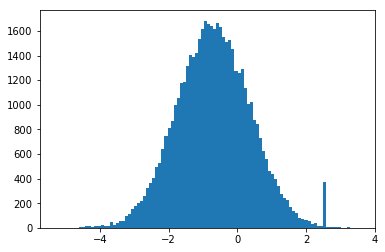

In [282]:
plt.hist(S.dot(w).flatten(), bins=100)
#plt.hist(U.dot(v).flatten(), bins=25, alpha=0.2)

(200, 50, 50)


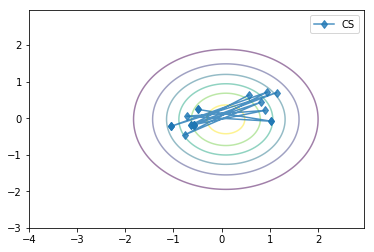

In [34]:
S = np.array(posterior_samples)
T = S[-150:-130, 40, :]
plt.plot(T.dot(v), T.dot(w), label='CS', alpha=0.8, marker='d')
#plt.scatter(T.dot(v).flatten(), T.dot(w).flatten())
#plt.scatter(init_chain2.dot(v), init_chain2.dot(w), alpha=0.5)
U = dd[dd.keys()[1]][-150:-140]
# U.shape
# #plt.scatter(U.dot(v), U.dot(w), alpha=0.3, label='HMC', marker='d')
# # plt.scatter(mu_.dot(v), mu_.dot(w), marker='d')
x = np.arange(-4.0, 3.0, delta)
y = np.arange(-3.0, 3.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, mux=mu_.dot(v)[0], muy=mu_.dot(w)[0], sigmax=0.99, sigmay=0.99)
plt.contour(X, Y, Z1, alpha=0.5, label='q')
plt.legend()

In [173]:
Sigma = np.diag(sigma_[0])
v.dot(Sigma.dot(v.T))

0.99494642

In [19]:
delta = 0.05

In [198]:
z1 = S[-150, 0, :]
z2 = S[-149, 0, :]
points = []
for l in  np.arange(0, 1.001, 0.05):
    z = l * z1 + (1-l * z2)
    points.append(np.copy(z))
    
interpolation = np.array(points)
interpolation.shape

(21, 50)

In [22]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

In [150]:
sigma_.dot(v)

array([-2.11689019, -2.11689019, -2.11689019, -2.11689019, -2.11689019,
       -2.11689019, -2.11689019, -2.11689019, -2.11689019, -2.11689019,
       -2.11689019, -2.11689019, -2.11689019, -2.11689019, -2.11689019,
       -2.11689019, -2.11689019, -2.11689019, -2.11689019, -2.11689019,
       -2.11689019, -2.11689019, -2.11689019, -2.11689019, -2.11689019,
       -2.11689019, -2.11689019, -2.11689019, -2.11689019, -2.11689019,
       -2.11689019, -2.11689019, -2.11689019, -2.11689019, -2.11689019,
       -2.11689019, -2.11689019, -2.11689019, -2.11689019, -2.11689019,
       -2.11689019, -2.11689019, -2.11689019, -2.11689019, -2.11689019,
       -2.11689019, -2.11689019, -2.11689019, -2.11689019, -2.11689019,
       -2.11689019, -2.11689019, -2.11689019, -2.11689019, -2.11689019,
       -2.11689019, -2.11689019, -2.11689019, -2.11689019, -2.11689019,
       -2.11689019, -2.11689019, -2.11689019, -2.11689019, -2.11689019,
       -2.11689019, -2.11689019, -2.11689019, -2.11689019, -2.11

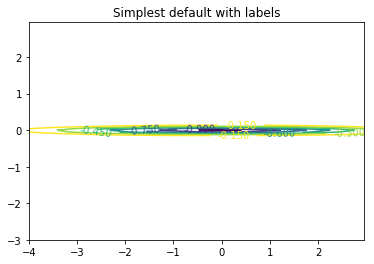

In [155]:
delta = 0.05
x = np.arange(-4.0, 3.0, delta)
y = np.arange(-3.0, 3.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, mux=mu_.dot(v)[0], muy=mu_.dot(w)[0], sigmax=sigma_[0].dot(v), sigmay=sigma_[0].dot(w))
Z2 = mlab.bivariate_normal(X, Y, 1.5, 0.5, 1, 1)
# difference of Gaussians
Z = Z1


# Create a simple contour plot with labels using default colors.  The
# inline argument to clabel will control whether the labels are draw
# over the line segments of the contour, removing the lines beneath
# the label
plt.figure()
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Simplest default with labels')

In [20]:
mu, log_sigma = encoder(inp)
mu_, sigma_ = sess.run([mu, tf.exp(log_sigma)], {inp: x0})

sigma_.shape

(50, 50)

In [203]:
Z = tf.placeholder(tf.float32, shape=(None, 50))
e = energy(Z, aux=inp)

e1 = sess.run(e, {Z: T, inp: x0})
e2 = sess.run(e, {Z: U, inp: x0})

InvalidArgumentError: Incompatible shapes: [2,784] vs. [150,784]
	 [[Node: logistic_loss_21/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Add_84, _arg_Placeholder_0_0)]]

Caused by op u'logistic_loss_21/mul', defined at:
  File "/home/danilevy/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/danilevy/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-203-a9d163416391>", line 2, in <module>
    e = energy(Z, aux=inp)
  File "<ipython-input-5-3a4105261f71>", line 37, in energy
    log_posterior = -tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=aux, logits=logits), axis=1)
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_impl.py", line 174, in sigmoid_cross_entropy_with_logits
    relu_logits - logits * labels,
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/math_ops.py", line 865, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/math_ops.py", line 1088, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1449, in _mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/danilevy/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Incompatible shapes: [2,784] vs. [150,784]
	 [[Node: logistic_loss_21/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Add_84, _arg_Placeholder_0_0)]]


In [217]:
S[-149, 0, :5], S[-148, 0, :5]

(array([-0.27081263,  0.52993363,  1.88966048,  1.3784467 ,  0.32094243], dtype=float32),
 array([ 0.37942019,  0.23738442, -2.12431741,  1.05054164,  0.66992515], dtype=float32))

In [241]:
U.shape

(150, 50, 50)

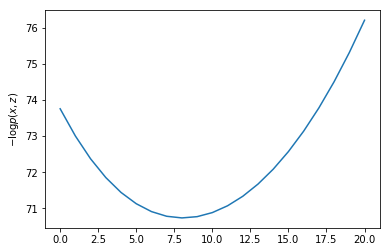

In [249]:
z1 = U[0, 2, :]
z2 = U[1, 2, :]
points = []
for l in  np.arange(0, 1.001, 0.05):
    z = l * z1 + (1-l) * z2
    points.append(np.copy(z))

interpolation = np.array(points)
interpolation.shape
# plt.plot(interpolation[:, 0], interpolation[:, 1])
e3 = sess.run(e, {Z: interpolation, inp: x0[:21, :]})
plt.plot(e3)
interpolation[0, :] - z2, interpolation[-1, :] - z1
plt.ylabel('$-\log p(x, z)$')

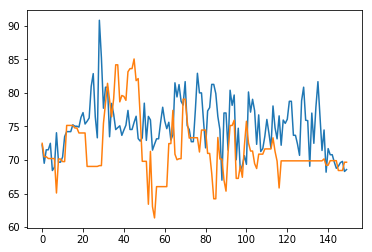

In [122]:
plt.plot(e1)
plt.plot(e2)

In [31]:
dd = {}
for eps in [0.1, 0.25, 0.5]:
    print eps
    hmc_dynamics = Dynamics(
        50, 
        energy, 
        T=5, 
        eps=eps, 
        hmc=True, 
    )
    z_start_hmc = tf.placeholder(tf.float32, shape=(None, 50))
    _, _, _, MH_HMC = propose(z_start_hmc, hmc_dynamics, do_mh_step=True, aux=inp)
    hmc_samples = []
    samples = np.copy(S[500, :, :])
    for t in range(200):
        hmc_samples.append(np.copy(samples))
        samples = sess.run(MH_HMC[0], {inp: x0[:50], z_start_hmc: samples})
    G = np.array(hmc_samples)
    dd[eps] = G
#     plt.plot(np.abs([autocovariance(G - mu, tau=t) for t in range(199)]), label='$\epsilon=%.2f$' % eps)
# plt.plot(np.abs([autocovariance(F[1000:, :, :] - mu, tau=t) for t in range(199)]), label='CS')
# plt.xlabel('# MH steps')
# plt.ylabel('Autocovariance')
# plt.legend()

0.1
0.25
0.5


In [ ]:
for t in range(50):
    plt.hist(F[1000:, :, t].flatten(), bins=100, alpha=0.1)
    plt.hist(G[:, :, t].flatten(), bins=100, alpha=0.1, color='red')
    plt.show()

In [ ]:
F[:, :, t].flatten().shape

In [ ]:
list_samples2 = []



In [ ]:
list_samples = []

samples = np.copy(init_chain)
for t in range(2000):
    list_samples.append(np.copy(samples))
    samples = sess.run(MH[0], {inp: x_0, z_start: samples})

In [ ]:
def autocovariance(X, tau=0):
    dT, dN, dX = np.shape(X)
    s = 0.
    for t in range(dT - tau):
        x1 = X[t, :, :]
        x2 = X[t+tau, :, :]

        s += np.sum(x1 * x2) / dN

    return s / (dT - tau)

In [ ]:
F = np.array(list_samples)
mu = F[1000:, :, :].mean(axis=(0, 1))

In [ ]:
G = np.array(list_samples2)

In [ ]:
#plt.plot(np.abs([autocovariance(G - mu, tau=t) for t in range(199)]))
plt.plot(np.abs([autocovariance(F[1000:, :, :] - mu, tau=t) for t in range(199)]))
plt.xlim(0, 60)

In [33]:
z_eval = tf.random_normal((64, 50))
x_eval = tf.nn.sigmoid(decoder(z_eval))

In [38]:
def plot_grid(S, width=8):
    sheet_width = width
    plt.figure(figsize=(12, 12))
    for i in xrange(S.shape[0]):
        plt.subplot(sheet_width, sheet_width, i + 1)
        plt.imshow(S[i], cmap='gray')
        plt.grid('off')
        plt.axis('off')

In [ ]:
train, test = get_data()

In [ ]:
train = np.reshape(train, (-1, 28, 28))

In [ ]:
mask

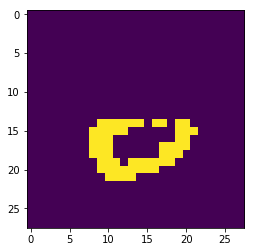

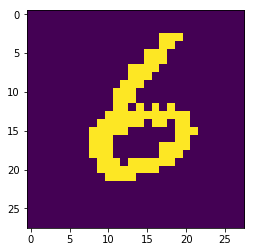

In [15]:
x0 = np.copy(x_train[66])
x0 = binarize(x0)
X0 = np.reshape(x0, (28, 28))
plt.imshow(X0)

# samples2 = []
# curr_sample = np.copy(x0).flatten()[None, :]
# for t in range(100):
#     current_z = sess.run(latent, {inp: curr_sample})
#     # curr_sample = sess.run(sample, {Z: current_z})
#     curr_probs = sess.run(probs, {Z: current_z})
#     samples2.append(np.copy(curr_probs))

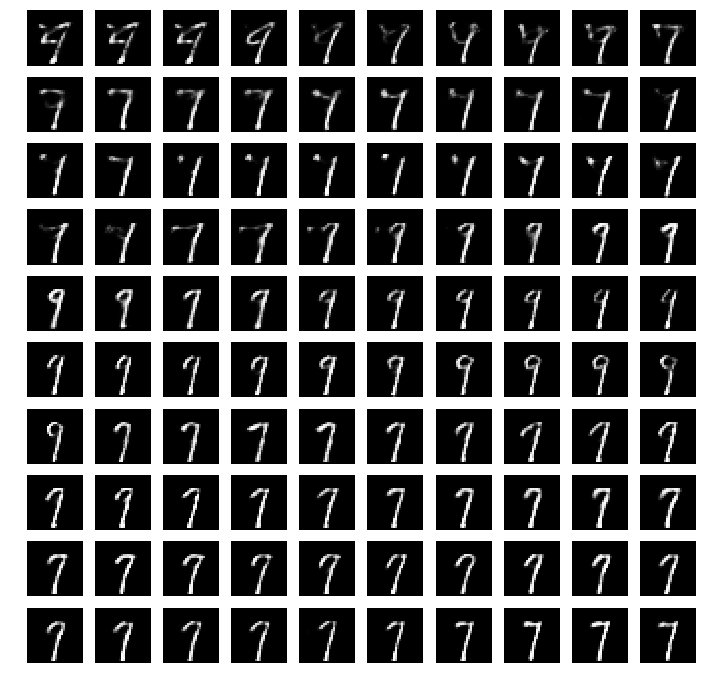

In [83]:
S = np.array(samples)
S = np.reshape(S, (-1, 28, 28))

plot_grid(S, width=10)

In [82]:
samples = []
x0 = viz[42]
x0[:14, :] = 0
x0 = x0.flatten()[None, :]
curr_x = np.copy(x0)
curr_z = np.copy(init_chain)

x0_2 = np.reshape(x0, (28, 28))
for t in range(100):
    curr_z, candidate_x, curr_probs = sess.run([MH[0], sample, probs], {inp: curr_x, z_start: curr_z})
    samples.append(np.copy(curr_probs))
    curr_x = np.reshape(candidate_x, (28, 28))
    curr_x[14:, :] = x0_2[14:, :]
    curr_x = curr_x.flatten()[None, :]

In [51]:
x0_old = np.copy(x0)

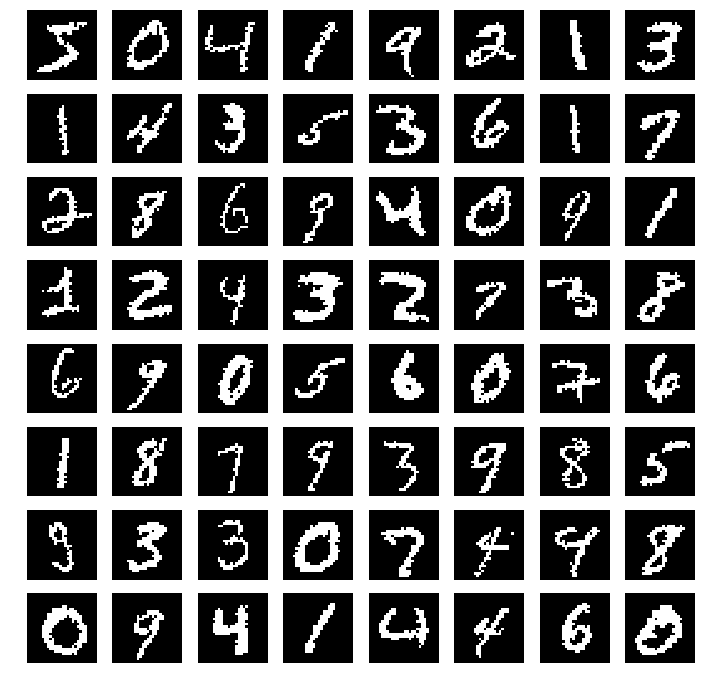

In [66]:
plot_grid(viz[:64])

In [65]:
viz = np.reshape(x_train, (-1, 28, 28))

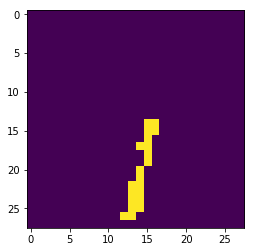

In [81]:
plt.imshow(mask(viz[42]))

In [74]:
def mask(x):
    y = np.copy(x)
    y[:14, :] = 0
    return y